In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import imageio
from torch import nn
%matplotlib inline

In [2]:
x = torch.unsqueeze(torch.linspace(0, 7, 100), dim=1) 

y = torch.exp(-x/5)*torch.sin(x)

In [3]:
#net is the network that approximates the time series P(t)
net = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
loss_func = torch.nn.MSELoss() 

In [6]:
#training
losses=[]
for t in range(3):
  
    prediction = net(x)     

    loss = loss_func(prediction, y) 
    losses.append(loss)
    print(loss)

    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()      

tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)


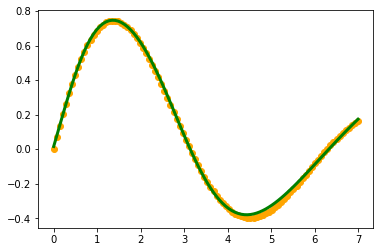

In [7]:
pred = net(x)
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

tensor(0.0484, grad_fn=<MseLossBackward0>)


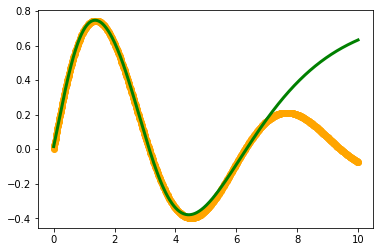

In [8]:
x = torch.unsqueeze(torch.linspace(0, 10, 800), dim=1) #OUT OF T
y = torch.exp(-x/5)*torch.sin(x)
pred = net(x)
loss = loss_func(pred, y)
print(loss)
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), pred.data.numpy(), 'g-', lw=3)

In [160]:
#analyticaly the neural network and the derivatives 

In [263]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))

def sigmoid_grad(x):
  return sigmoid(x)*(1- sigmoid(x))

def sigmoid_grad_grad(x):
  return sigmoid_grad(x) -2*sigmoid(x)*sigmoid_grad(x)

def neural_network(x,weights,bias):
    s_z = sigmoid(torch.matmul(x,weights[0])+bias[0])
    return torch.matmul(s_z, weights[1]) + bias[1]
# first derivative of net
def dN_dx(weights, x):
    s_z_grad = sigmoid_grad(torch.matmul(x,weights[0])+bias[0]) 
    mul=torch.mul(weights[0].T,weights[1])
    return torch.matmul(s_z_grad,mul)

In [264]:
#second derivative
def d_dN_dx(weights,x):
  s_z_grad = sigmoid_grad_grad(torch.matmul(x,weights[0])+bias[0])
  mul=torch.mul((weights[0].T)**2,weights[1])
  return torch.matmul(s_z_grad,mul)

In [265]:
def error(pred,target): return ((pred-target)**2).mean() 

In [266]:
#initialize weights and biases
weights = [torch.randn((1,10),  requires_grad=True), torch.randn((10,1),  requires_grad=True)]
bias = [torch.randn(10,  requires_grad=True), torch.randn(1,  requires_grad=True)]

In [315]:
x = torch.unsqueeze(torch.linspace(0, 7, 100), dim=1) 
y = torch.exp(-x/5)*torch.sin(x)

In [316]:
epochs=3
lr=0.01
for i in range(epochs):
    pred = neural_network(x,weights,bias)
    loss = error(pred,y)
    loss.backward()
    weights[0].data -= lr*weights[0].grad.data
    weights[1].data -= lr*weights[1].grad.data
    bias[0].data -= lr*bias[0].grad.data
    bias[1].data -= lr*bias[1].grad.data

 
    weights[0].grad.zero_()
    weights[1].grad.zero_()
    bias[0].grad.zero_()
    bias[1].grad.zero_()

    print("Loss: ", loss.item())

Loss:  0.0009916801936924458
Loss:  0.000991349807009101
Loss:  0.0009910191874951124


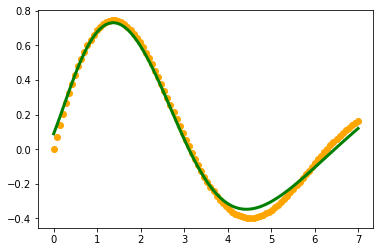

In [317]:
N=neural_network(x,weights,bias)
fig, ax = plt.subplots()
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), N.data.numpy(), 'g-', lw=3)

Suppose $$P(t) \approx N(t)$$ and $$ \frac{dN^{2}}{dt^{2}}=net*net1 + net2$$ with loss function $$ L = \frac{dN^{2}}{dt^{2}} - net*net1 - net2$$

In [ ]:
#second approach

In [360]:
x = torch.unsqueeze(torch.linspace(0, 7, 1000), dim=1) 

In [361]:
net1 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )

In [362]:
def loss(x):

    x.requires_grad = True
    #N = net(x)
    N = neural_network(x, weights, bias)
    dN_x_x = d_dN_dx(weights,x)

    #dN_dx = torch.autograd.grad(N, x, grad_outputs=torch.ones_like(N),create_graph=True)[0]
    #dN_x_x = torch.autograd.grad(dN_dx, x, grad_outputs=torch.ones_like(dN_dx),create_graph=True )[0]

    return  torch.mean( ( dN_x_x - net1(x)*N)  ** 2)

In [363]:
optimizer = torch.optim.Adam(net1.parameters(), lr=0.001)

In [372]:
def closure():
    
    l = loss(x)
    losses.append(l)
    
    optimizer.zero_grad()
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(4):
    optimizer.step(closure)

loss: 0.005661093629896641
loss: 0.0056604924611747265
loss: 0.005659890361130238
loss: 0.005659288726747036


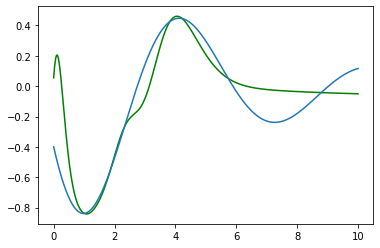

In [374]:
#check the ode 
x = torch.Tensor(np.linspace(0, 10, 1000)[:, None]) 
y=torch.exp(-(x/5))*torch.sin(x)
dy = torch.exp(-(x/5))*(-1/5)*torch.sin(x) + torch.exp(-(x/5))*torch.cos(x)
ddy = -(1/5)*dy - y -(1/5)*torch.exp(-(x/5))*torch.cos(x)
pred = net(x)*net1(x)
plt.plot(x.data.numpy(), pred.data.numpy(), 'g-')
plt.plot(x.data.numpy(), ddy.data.numpy())

In [ ]:
#Train net2

In [375]:
net2 = torch.nn.Sequential(
        torch.nn.Linear(1, 10),
        torch.nn.Sigmoid(),
        torch.nn.Linear(10, 1),
    )

In [376]:
def loss_net2(x):

    x.requires_grad = True
    #N = net(x)
    N = neural_network(x, weights, bias)
    dN_x_x = d_dN_dx(weights,x)

    #dN_dx = torch.autograd.grad(N, x, grad_outputs=torch.ones_like(N),create_graph=True)[0]
    #dN_x_x = torch.autograd.grad(dN_dx, x, grad_outputs=torch.ones_like(dN_dx),create_graph=True )[0]

    return  torch.mean( ( dN_x_x - net1(x)*N -net2(x))  ** 2)

In [377]:
optimizer = torch.optim.Adam(net2.parameters(), lr=0.001)

In [381]:
def closure():
    
    l = loss_net2(x)
    losses.append(l)
    
    optimizer.zero_grad()
    l.backward()
    print(f"loss: {l}")
    return l

for i in range(4):
    optimizer.step(closure)

loss: 0.003923005424439907
loss: 0.003922479692846537
loss: 0.003921953029930592
loss: 0.0039214263670146465


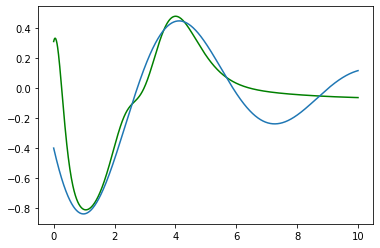

In [382]:
#check the ode 
x = torch.Tensor(np.linspace(0, 10, 1000)[:, None]) 
y=torch.exp(-(x/5))*torch.sin(x)
dy = torch.exp(-(x/5))*(-1/5)*torch.sin(x) + torch.exp(-(x/5))*torch.cos(x)
ddy = -(1/5)*dy - y -(1/5)*torch.exp(-(x/5))*torch.cos(x)
pred = neural_network(x,weights,bias)*net1(x) +net2(x)
plt.plot(x.data.numpy(), pred.data.numpy(), 'g-')
plt.plot(x.data.numpy(), ddy.data.numpy())

In [383]:
#solution of ode 
NN = nn.Sequential(nn.Linear(1, 10), nn.Sigmoid(), nn.Linear(10,1))
#A = net(x[0])
Psi_t = lambda x: x + x**2 * NN(x) #NN is responsible for the solution of O.D.E
f = lambda x: net1(x)*neural_network(x,weights,bias) + net2(x) #they are both trained. 

In [384]:
def loss_fun(x):

    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                        create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x),
                                            create_graph=True )[0]

    return  torch.mean( ( Psi_t_x_x - f(x) )  ** 2)

In [385]:
optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)

In [388]:
def closure():

    optimizer.zero_grad()
    l = loss_fun(x)
    print(l)
    #l.backward()
    l.backward(retain_graph=True)
    return l

for i in range(4):
    optimizer.step(closure)

tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


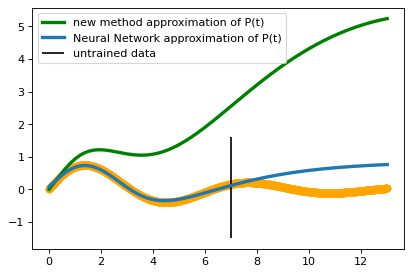

In [390]:
x = torch.unsqueeze(torch.linspace(0, 13, 800), dim=1) 
y = torch.exp(-x/5)*torch.sin(x)
p_t_second = Psi_t(x)
p_t_first = neural_network(x,weights,bias)
fig, ax = plt.subplots(dpi=80)
ax.scatter(x.data.numpy(),y.data.numpy(), color = "orange")
ax.plot(x.data.numpy(), p_t_second.data.numpy(), 'g-', lw=3, label ='new method approximation of P(t)')
ax.plot(x.data.numpy(), p_t_first.data.numpy(), lw=3, label ='Neural Network approximation of P(t)')

ax.vlines(x=7, ymin=-1.5, ymax=1.6, color='black', label='untrained data')


#ax.plot(x.data.numpy(), yrk, lw=3, label ='RK approximation of P(t)')

plt.legend(loc='best');